# Tradução com transformers

Nesse notebook desenvolveremos uma tradução de máquina utilizando modelo de Transformer. 
A idéia central do Transromer é a autoatenção, que é a capacidade de atender a diferentes posições da sequência de entrada para calcular uma representação dessa. O Transformer cria pilhas de camadas de autoatenção. 

Uma variável de tamanho de entrada alças modelo transformador usando pilhas de camadas auto-atenção, em vez de RNNs ou CNNs . Esta arquitetura geral tem uma série de vantagens:

* Não faz suposições sobre as relações temporais / espaciais entre os dados. Isso é ideal para processar um conjunto de objetos (por exemplo, unidades StarCraft ).
* As saídas da camada podem ser calculadas em paralelo, em vez de uma série como um RNN.
* Os itens distantes podem afetar a saída uns dos outros sem passar por muitas etapas RNN ou camadas de convolução (consulte Scene Memory Transformer, por exemplo).
* Ele pode aprender dependências de longo alcance. Este é um desafio em muitas tarefas de sequência.

As desvantagens dessa arquitetura são:

* Para uma série temporal, a saída de um intervalo de tempo é calculada a partir de todo o histórico, em vez de apenas as entradas e o estado oculto atual. Isso pode ser menos eficiente.
* Se a entrada não tem uma relação temporal / espacial, como texto, deve ser adicionado alguns codificação posicional ou o modelo vai ver efetivamente um saco de palavras.

**O Modelo nesse notebook vai seguir os passos de ensinamentos disponibilizados pelo google Tensorflow.** 

## Começamos com as configurações e Biblioteca

In [ ]:
#Habilitando a gpu no google colab
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install -q tensorflow_datasets
!pip install -q tensorflow_text

     |████████████████████████████████| 3.4MB 17.5MB/s 


In [ ]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text

In [ ]:
#Esconder avisos
logging.getLogger('tensorflow').setLevel(logging.ERROR)

## Baixando o Dataset

Agora que terminamos com as configurações, vamos baixar o Dataset que será usando nese notebook
Iremos usar dataset disponibilizado pelo TensorFlow para carregar as traduções de Português-Inglês do prójeto do [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

Esse dataset contem aproximadamente 50 mil exemplos, 1100 exemplos de validações e 2000 exemplos para teste

In [ ]:
exemplos, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train, validation = exemplos['train'], exemplos['validation']

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete9RKBKC/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete9RKBKC/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete9RKBKC/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [ ]:
#O objeto tf.data.Dataset retornado pelos conjuntos de dados TensorFlow produz pares de exemplos de texto:
for exemplos_pt, exemplos_en in train.batch(3).take(2):
  for pt in exemplos_pt.numpy():
    print(pt.decode('utf-8'))

    print()

    for en in exemplos_en.numpy():
      print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
mas e se estes fatores fossem ativos ?

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .

and this conscious defiance is why i , as an agnostic , can still have faith .
you can use everything on the table on me .
`` i write a lot about `` '' security theater , '' '' which ar

## Tokenização e detokenização de texto

Antes de trinar o modelo precisamos converter o texto para alguma representação númerica. O método mais conhecido é converter o texto em sequeência de IDs de token, que são como índices em uma incoporação

Utilizaremos o o modelo ensino pelo google neste [tutoial](https://www.tensorflow.org/tutorials/tensorflow_text/subwords_tokenizer). Otimizamos para este conjunto de dados. 

Vamos começar naixando e importando o modelo:

In [ ]:
modelo = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{modelo}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{modelo}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

188416/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
# Vamos dar uma olhada no tf.saved_model que contem dois modelos de tokenizers de texto, um para inglês e outro para português.
tokenizers = tf.saved_model.load(modelo)
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

O método tokenize converte um lote de strings em um lote preenchido de IDs de token. Com esse método, ele divide a pontução, letras minúsculas e unicode-normaliza a entrada antes de tokenizar. 

In [ ]:
for en in exemplos_en.numpy():
  print(en.decode('utf-8'))

and this conscious defiance is why i , as an agnostic , can still have faith .
you can use everything on the table on me .
`` i write a lot about `` '' security theater , '' '' which are products that make people feel secure , but do n't actually do anything . ''


In [ ]:
encoded = tokenizers.en.tokenize(exemplos_en)

for row in encoded.to_list():
  print(row)

[2, 72, 81, 2508, 2159, 3072, 1282, 80, 192, 45, 13, 100, 111, 6040, 3176, 3186, 13, 94, 235, 89, 1938, 15, 3]
[2, 79, 94, 212, 299, 92, 71, 1356, 92, 114, 15, 3]
[2, 36, 36, 45, 712, 37, 199, 95, 36, 36, 9, 9, 892, 3270, 13, 9, 9, 9, 9, 148, 86, 1321, 75, 161, 104, 309, 1871, 13, 87, 91, 50, 9, 56, 150, 91, 440, 15, 9, 9, 3]


In [ ]:
# O método detokenize faz uma tentativa de converter esses vitores de token de volta em texto legível. Vamos testa-los!
retornar = tokenizers.en.detokenize(encoded)
for line in retornar.numpy():
  print(line.decode('utf-8'))

and this conscious defiance is why i , as an agnostic , can still have faith .
you can use everything on the table on me .
` ` i write a lot about ` ` ' ' security theater , ' ' ' ' which are products that make people feel secure , but do n ' t actually do anything . ' '


In [ ]:
# O método lookup nível inferior converte de token-IDs em texto de token:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'this', b'conscious', b'de', b'##fi', b'##ance', b'is', b'why', b'i', b',', b'as', b'an', b'ag', b'##no', b'##stic', b',', b'can', b'still', b'have', b'faith', b'.', b'[END]'], [b'[START]', b'you', b'can', b'use', b'everything', b'on', b'the', b'table', b'on', b'me', b'.', b'[END]'], [b'[START]', b'`', b'`', b'i', b'write', b'a', b'lot', b'about', b'`', b'`', b"'", b"'", b'security', b'theater', b',', b"'", b"'", b"'", b"'", b'which', b'are', b'products', b'that', b'make', b'people', b'feel', b'secure', b',', b'but', b'do', b'n', b"'", b't', b'actually', b'do', b'anything', b'.', b"'", b"'", b'[END]']]>

## Configurando o pipeline de entrada

Agora que terminamos de analisar e os dados do dataset podemos começar a contruir um pipeline de entrada adequado para treinamento. 
Iremos nesses passos aplicar algumas transformações ao conjuto de dados. 

A próxima função será usada para codificar os lotes de textos bruto:

In [ ]:
def tokenize_paires(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Converte de ragged para dense, preenchendo com zeros. 
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Converte de ragged para dense, preenchendo com zeros. 
    en = en.to_tensor()
    return pt, en

In [ ]:
# Pipeline de entrada simples que processa, embaralha e agrupa os dados:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_paires, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train)
val_batches = make_batches(validation)

# Condificação posicional

Vamos agora implmentar a codificação posicional para fornecer ao modelo algumas informações sobre a posição relativa das palavras e frase.

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # aplicar a função seno a índices pares na matriz; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # aplicar a função cosseno a índices pares na matriz; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


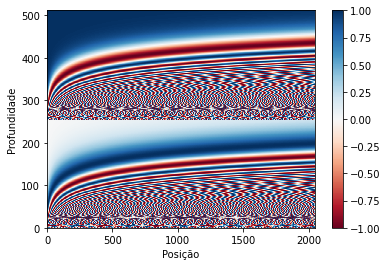

In [ ]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Vamos olhar as dimensões d plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Profundidade')
plt.xlabel('Posição')
plt.colorbar()
plt.show()

## Mascaramento

Vamos agora mascarar todos os tokens de pad no lote da sequência. Isso garante que o modelo não trate o preenchimento como entrada. 
A máscara indica onde o calor pad 0 está presente: ela produz um 1 nesses locais e um 0 caso contrário.

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # Adicionando dimensões extras para adcionar o preenchimento 'padding' aos logys de atenção.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (tamanho do batch, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

A máscara de antecipação é usada para mascarar os tokens futuros em uma sequência. 

Isso siginifica que, para prever terceira palavra, apenas a primeira e asegunda palavra serão usadas. Da mesma forma, para prever a quarta palavra, apenas a primeiram a segunda e terceira palavras serão usadas e assim por diente. 

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Função de atenção ao produto escalonado

A função de atenção usada pelo transformador tem três entradas: Q (consulta), K (chave), V (valor). 
Isso é feito porque para grandes valores de profundidade, o produto escalar cresce em magnitude empurrando a função softmax onde tem pequenos gradientes resultando em um softmax muito difícil.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  '''Calcule os pesos de atenção.
    q, k, v devem ter dimensões principais correspondentes.
    k, v deve ter a penúltima dimensão correspondente, ou seja: seq_len_k = seq_len_v.
    A máscara tem diferentes formas dependendo do seu tipo (preenchimento ou visualização)
    mas deve ser transmitido para adição.

    Args:
      q: formato da query == (..., seq_len_q, depth)
      k: formato da chave == (..., seq_len_k, depth)
      v: formato do valor == (..., seq_len_v, depth_v)
      máscara: tensor flutuante com formato transmitível
            para (..., seq_len_q, seq_len_k). O padrão é None.

    Retorna:
      output, attention_weights
    '''

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # escala matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # adicione a máscara ao tensor escalado.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax é normalizado no último eixo (seq_len k) de modo que as pontuações somam +1
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

Como a normalização softmax é feita em K, seus valores decidem a importância de Q.

A saída representa a multiplicação dos pesos de atenção e o vetor V(valor).
Com isso garantimentos que as palavras nais quais desejamos se concentrar sejam mantidas e as irrelevantes sejam eliminadas 

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Os pesos de atenções são:')
  print(temp_attn)
  print('A saída é:')
  print(temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# Essa `query` se alinha com a segunda `chave`,
# para que o segundo valor seja retornado.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Os pesos de atenções são:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
A saída é:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# Esta query se alinha com uma chave repetida (terceira e quarta),
# para que todos os valores associados tenham a média.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Os pesos de atenções são:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
A saída é:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
# Está query se alinha igualmente com a primeira e segunda chava,
# para que sseus valores sejam calculados.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Os pesos de atenções são:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
A saída é:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [ ]:
#Passando todas as queries juntas
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Os pesos de atenções são:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
A saída é:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Função Atenção multi-cabeça

A atenção de várias cabeças consiste em quatro partes:

* Camadas lineares e divididas em cabeças.
* Atenção ao produto escalado em escala.
* Concatenação de cabeças.
* Camada linear final.

Cada bloco de atenção com várias cabeças recebe três entradas; Q (consulta), K (chave), V (valor). Eles são colocados em camadas lineares (densas) e divididos em várias cabeças.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Divide a última dimensão em (núm_heads, depth).
     Transponha o resultado de forma que a forma seja (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Criando uma camada MultiHeadAttention, temos que em cada loca da sequência, y, o MultiHeadAttention executa toda as 8 cabeças em todos os outros locais na sequência, retornando um novo vetor do mesmo comprimento local.

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Função Rede de feed forward inteligente

A rede de alimentação direta pontual em duas camadas totalmente conectadas com uma ativação ReLu entre elas

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Criando o Codificador e Decodificador

O modelo do transformador segue o mesmo padrão geral que o modelo de sequência padrão para sequência com atenção .

* A sentença de entrada é passada por N camadas de codificador que geram uma saída para cada palavra / token na sequência.
* O decodificador atende à saída do codificador e sua própria entrada (autoatenção) para prever a próxima palavra.

### Camada codificadora
Cada camada do codificador consiste em subcamadas:

1. Atenção multi-cabeça (com máscara de preenchimento)
2. Aponte redes de feed forward inteligentes.
Cada uma dessas subcamadas tem uma conexão residual em torno dela seguida por uma normalização de camada. As conexões residuais ajudam a evitar o problema do gradiente de desaparecimento em redes profundas.

A saída de cada subcamada é LayerNorm(x + Sublayer(x)) . A normalização é feita no eixo d_model (último). Existem N camadas de codificador no transformador.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Camada decodificadora

Cada camada do decodificador consiste em subcamadas:

1. Atenção de várias cabeças mascarada (com máscara de observação e máscara de preenchimento)
2. Atenção multi-cabeça (com máscara de enchimento). V (valor) e K (chave) recebem a saída do codificador como entradas. Q (consulta) recebe a saída da subcamada de atenção com várias cabeças mascaradas.
3. Aponte redes de feed forward inteligente

Cada uma dessas subcamadas tem uma conexão residual em torno dela seguida por uma normalização de camada. A saída de cada subcamada é LayerNorm(x + Sublayer(x)) . A normalização é feita no eixo d_model (último).

Existem N camadas de decodificador no transformador.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Codificador

O Encoder consiste em:

1. Incorporação de entrada
2. Codificação Posicional
3. N camadas codificadoras

A entrada é submetida a uma incorporação que é somada à codificação posicional. A saída desse somatório é a entrada para as camadas do codificador. A saída do codificador é a entrada para o decodificador.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decodificador

O Decoder consiste em:

1. Incorporação de saída
2. Codificação Posicional
3. N camadas de decodificador

O destino é submetido a uma incorporação que se soma à codificação posicional. A saída desse somatório é a entrada para as camadas do decodificador. A saída do decodificador é a entrada para a camada linear final.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformer

Agora podemos focar na principal implementação do problema, Transformer.

O Transformer consiste no condificador, decodificador e uma camada linear final. A saída do decodificador é a entrada para a camada linear e sua saída é retornada. 

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [ ]:
# Hiperparâmtros que serão utilizados
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Otimizador

Usaremos o otimizador Adam com um programador de taxa de aprendizagem personalizado. 

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Passos')

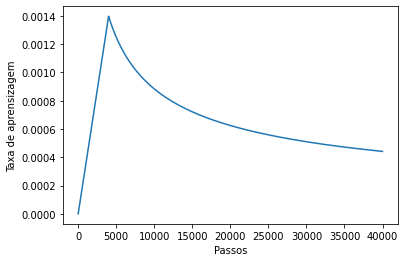

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Taxa de aprensizagem")
plt.xlabel("Passos")

## Loss Functions e Métricas

Como as sequências de destino são preenchidas, é importante uma máscara de preenchimento ao calcular a perda. 

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='Perda')
train_accuracy = tf.keras.metrics.Mean(name='acurácia')

In [ ]:
# Treinamento

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
# salvando pontos de verificação a cada n épocas.

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Se existir um ponto de redificação, restaura o ponto de verificação mais recente.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Último checkpoint restaurando, aheee!!')

In [ ]:
# números de Epochs
EPOCHS = 20

In [ ]:
# O @tf.function trace-compiles train_step em um g´rafico TF para mais rápido 
# execução. A função é especializada na forma precisa do argumento
# tensores. Para evitar o novo rastreamento devido aos comprimentos de sequência variáveis ou variáveis
# tamanhos de lote (o último lote é menor), use input_signature para especificar
# formas mais genéricas.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

Utilizaremos o português como idiotma de entrada e o inglês como saída. 

Hora de treinar o modelo e ir tomar um café!!


In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> português, tar -> Inglês
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Perda {train_loss.result():.4f} Acurácia {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Perda {train_loss.result():.4f} Acurácia {train_accuracy.result():.4f}')

  print(f'Tempo para exercutar 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Perda 8.8783 Acurácia 0.0000
Epoch 1 Batch 50 Perda 8.8130 Acurácia 0.0004
Epoch 1 Batch 100 Perda 8.7115 Acurácia 0.0207
Epoch 1 Batch 150 Perda 8.5990 Acurácia 0.0317
Epoch 1 Batch 200 Perda 8.4602 Acurácia 0.0370
Epoch 1 Batch 250 Perda 8.2921 Acurácia 0.0412
Epoch 1 Batch 300 Perda 8.1017 Acurácia 0.0459
Epoch 1 Batch 350 Perda 7.9046 Acurácia 0.0544
Epoch 1 Batch 400 Perda 7.7154 Acurácia 0.0626
Epoch 1 Batch 450 Perda 7.5467 Acurácia 0.0701
Epoch 1 Batch 500 Perda 7.3976 Acurácia 0.0774
Epoch 1 Batch 550 Perda 7.2622 Acurácia 0.0848
Epoch 1 Batch 600 Perda 7.1343 Acurácia 0.0927
Epoch 1 Batch 650 Perda 7.0151 Acurácia 0.1000
Epoch 1 Batch 700 Perda 6.9044 Acurácia 0.1070
Epoch 1 Batch 750 Perda 6.8031 Acurácia 0.1132
Epoch 1 Batch 800 Perda 6.7085 Acurácia 0.1193
Epoch 1 Perda 6.6922 Acurácia 0.1204
Tempo para exercutar 1 epoch: 115.08 secs

Epoch 2 Batch 0 Perda 5.4740 Acurácia 0.1949
Epoch 2 Batch 50 Perda 5.2388 Acurácia 0.2136
Epoch 2 Batch 100 Perda 5.1879 Ac

## Avaliação do Modelo

In [ ]:
def evaluate(frase, max_length=40):
  # a frase do inp é português, portanto, adicionando o token de início e fim
  frase = tf.convert_to_tensor([frase])
  frase = tokenizers.pt.tokenize(frase).to_tensor()

  encoder_input = frase

  # como o alvo é o inglês, a primeira palavra para o transformador deve ser o token de início em inglês.

  start, end = tokenizers.en.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # seleciona a última palavra da dimensão seq_len
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatene o id previsto para a saída que é fornecida ao decodificador como sua entrada.
    output = tf.concat([output, predicted_id], axis=-1)

    # retornar o resultado do id previsto é igual ao token final
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizers.en.detokenize(output)[0]  # shape: ()

  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attention_weights

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Entrada:":15s}: {sentence}')
  print(f'{"Predição":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Verdade Fundamental":15s}: {ground_truth}')

In [ ]:
frase = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = evaluate(frase)
print_translation(frase, translated_text, ground_truth)

Entrada:       : este é um problema que temos que resolver.
Predição       : this is a problem we have to solve .
Verdade Fundamental: this is a problem we have to solve .


In [ ]:
sentence = "Estudar ciência de dados é muito excitante."
ground_truth = "Studying data science is very exciting."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Entrada:       : Estudar ciência de dados é muito excitante.
Predição       : study data science is very exciting .
Verdade Fundamental: Studying data science is very exciting.


In [ ]:
sentence = "Esse problema utilizando transformer para traduções foi díficil mas é ótimo ver o resultado final. ."
ground_truth = "This problem using transformer for translations was difficult but it is great to see the final result."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Entrada:       : Esse problema utilizando transformer para traduções foi díficil mas é ótimo ver o resultado final. .
Predição       : that problem with redesvader to tradradradment was hard , but it ' s great to see the end of the end .
Verdade Fundamental: This problem using transformer for translations was difficult but it is great to see the final result.


Podemos ver que nessa última frase o tradutor não foi tão bem. O que podemos fazer é adcionar parcelas de atenção!

## Parcelas de atenção 
A função de evaluate também retorna um dicionário de mapas de atenção que podemos usar para visualizar o funcionamento interno do modelo:


In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([33, 26])

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(26,), dtype=string, numpy=
array([b'[START]', b'esse', b'problema', b'utilizando', b't', b'##ra',
       b'##ns', b'##forme', b'##r', b'para', b't', b'##ra', b'##d',
       b'##ucoes', b'foi', b'dificil', b'mas', b'e', b'otimo', b'ver',
       b'o', b'resultado', b'final', b'.', b'.', b'[END]'], dtype=object)>

In [ ]:
translated_tokens

<tf.Tensor: shape=(34,), dtype=string, numpy=
array([b'[START]', b'that', b'problem', b'with', b'red', b'##es', b'##va',
       b'##der', b'to', b't', b'##ra', b'##d', b'##ra', b'##d', b'##ra',
       b'##d', b'##ment', b'was', b'hard', b',', b'but', b'it', b"'",
       b's', b'great', b'to', b'see', b'the', b'end', b'of', b'the',
       b'end', b'.', b'[END]'], dtype=object)>

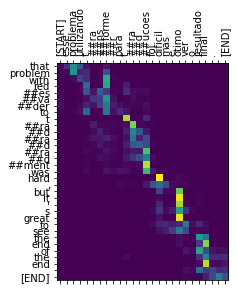

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

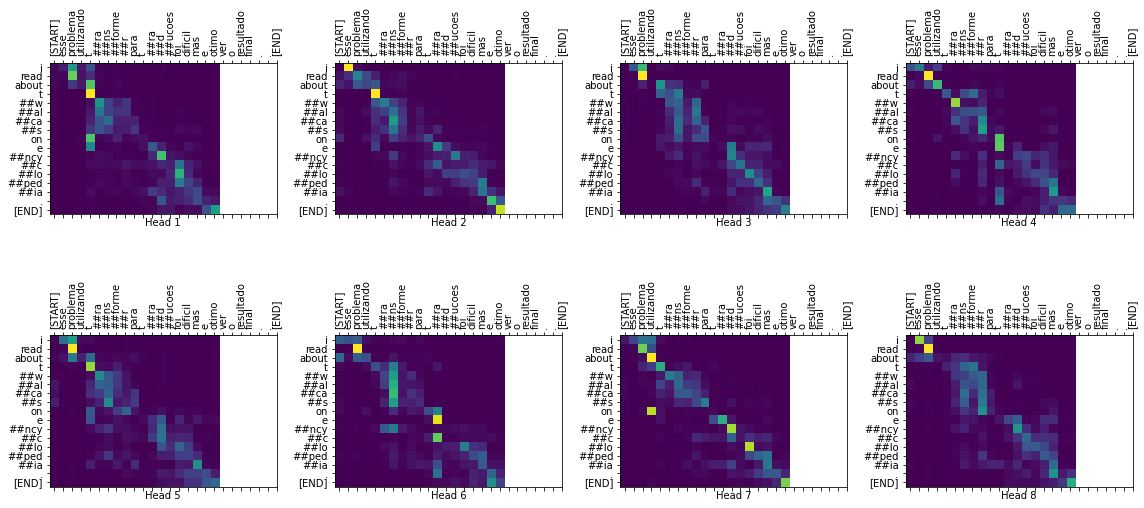

In [ ]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

Entrada:       : Eu li sobre triceratops na enciclopédia.
Predição       : i read about twalcas on encyclopedia .
Verdade Fundamental: I read about triceratops in the encyclopedia.


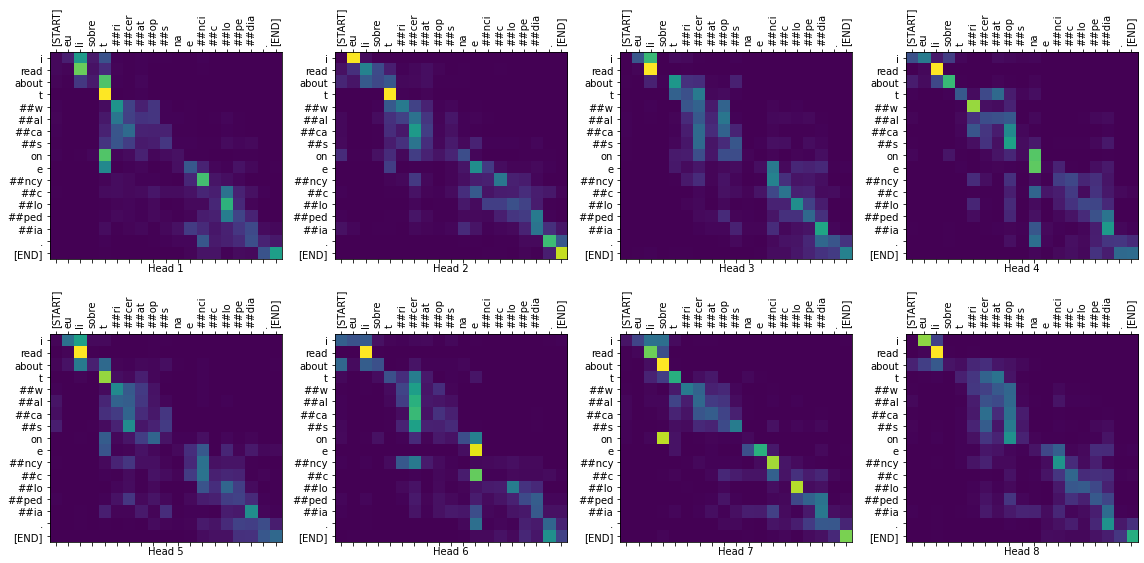

In [ ]:
frase = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = evaluate(frase)
print_translation(frase, translated_text, ground_truth)

plot_attention_weights(frase, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Conclusão

Nesse notebook aprendemos sobre condificação posicional, atenção de várias cabeças, a importância do mascaramento e como criar um transformador. 

In [ ]:
sentence = "Muito obrigado pelo desafio!"
ground_truth = "Thank you very much for the challenge!"

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Entrada:       : Muito obrigado pelo desafio!
Predição       : thank you so much for the challenge .
Verdade Fundamental: Thank you very much for the challenge!


In [ ]:
sentence = "Hora de pesquisar e quebrar a cabeça com o próximo desafio."
ground_truth = "Time to research and puzzle over the next challenge."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Entrada:       : Hora de pesquisar e quebrar a cabeça com o próximo desafio.
Predição       : time to do is break the head with the next challenge .
Verdade Fundamental: Time to research and puzzle over the next challenge.
